In [1]:
# Environment setup
import sys
from pathlib import Path

# Add src to path
workspace_root = Path.cwd()
while not (workspace_root / 'src').exists() and workspace_root != workspace_root.parent:
    workspace_root = workspace_root.parent

sys.path.insert(0, str(workspace_root / 'src'))

print(f"Project root: {workspace_root}")
print(f"Python version: {sys.version}")
print("✓ Environment configured")

Project root: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment
Python version: 3.12.0 (v3.12.0:0fb18b02c8, Oct  2 2023, 09:45:56) [Clang 13.0.0 (clang-1300.0.29.30)]
✓ Environment configured


In [17]:
# Imports
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import json
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

# Thesis pipeline utilities
from thesis_pipeline.io.parquet import read_parquet, write_parquet

# Plotting setup
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ All imports successful")

✓ All imports successful


## 1. Load Daily Polarization Data

Load daily polarization time series for both Reddit and News.

In [18]:
# Paths
reddit_polarization_dir = workspace_root / 'data' / '04_polarization' / 'reddit'
news_polarization_dir = workspace_root / 'data' / '04_polarization' / 'news'
forecasting_dir = workspace_root / 'data' / '05_forecasting'
forecasting_dir.mkdir(parents=True, exist_ok=True)

print(f"Reddit polarization: {reddit_polarization_dir}")
print(f"News polarization: {news_polarization_dir}")
print(f"Forecasting output: {forecasting_dir}")

Reddit polarization: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/04_polarization/reddit
News polarization: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/04_polarization/news
Forecasting output: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/05_forecasting


In [19]:
# Load daily polarization data
reddit_daily_file = reddit_polarization_dir / 'polarization_daily.parquet'
news_daily_file = news_polarization_dir / 'polarization_daily.parquet'

data_sources = {}

if reddit_daily_file.exists():
    df_reddit = read_parquet(reddit_daily_file)
    df_reddit['source'] = 'reddit'
    
    # Ensure date column exists
    if 'date' in df_reddit.columns:
        df_reddit['date'] = pd.to_datetime(df_reddit['date'])
    else:
        raise ValueError("Reddit data missing 'date' column")
    
    data_sources['reddit'] = df_reddit
    print(f"✓ Loaded Reddit: {len(df_reddit):,} daily observations")
    print(f"  Topics: {df_reddit['topic'].nunique()}")
    print(f"  Date range: {df_reddit['date'].min()} to {df_reddit['date'].max()}")
else:
    print(f"⚠️  Reddit daily data not found: {reddit_daily_file}")

if news_daily_file.exists():
    df_news = read_parquet(news_daily_file)
    df_news['source'] = 'news'
    
    # Ensure date column exists
    if 'date' in df_news.columns:
        df_news['date'] = pd.to_datetime(df_news['date'])
    else:
        raise ValueError("News data missing 'date' column")
    
    data_sources['news'] = df_news
    print(f"\n✓ Loaded News: {len(df_news):,} daily observations")
    print(f"  Topics: {df_news['topic'].nunique()}")
    print(f"  Date range: {df_news['date'].min()} to {df_news['date'].max()}")
else:
    print(f"\n⚠️  News daily data not found: {news_daily_file}")

if not data_sources:
    raise FileNotFoundError(
        "No daily polarization data found. Please run polarization notebooks first:\n"
        "  - Reddit: notebook 17\n"
        "  - News: notebook 25"
    )

print(f"\n✓ Loaded {len(data_sources)} data source(s): {list(data_sources.keys())}")

✓ Loaded Reddit: 250 daily observations
  Topics: 5
  Date range: 2016-09-01 00:00:00 to 2016-10-31 00:00:00

✓ Loaded News: 54 daily observations
  Topics: 5
  Date range: 2016-09-11 00:00:00 to 2016-10-31 00:00:00

✓ Loaded 2 data source(s): ['reddit', 'news']


## 2. Prepare Data for Forecasting

Prepare time series for each topic and source combination.

In [20]:
# Prepare time series data
def prepare_time_series(df, topic, metric='er_polarization'):
    """
    Prepare time series for a specific topic.
    
    Args:
        df: DataFrame with daily polarization data
        topic: Topic to filter for
        metric: Metric to forecast (default: er_polarization)
    
    Returns:
        pd.Series with datetime index
    """
    topic_data = df[df['topic'] == topic].copy()
    topic_data = topic_data.sort_values('date')
    
    # Create time series with datetime index
    ts = pd.Series(
        data=topic_data[metric].values,
        index=pd.DatetimeIndex(topic_data['date']),
        name=metric
    )
    
    return ts

# Get all available topics
all_topics = set()
for source_name, df in data_sources.items():
    all_topics.update(df['topic'].unique())

print(f"Available topics: {sorted(all_topics)}")
print(f"Total: {len(all_topics)} topics")

Available topics: ['climate_change', 'donald_trump', 'gun_control', 'immigration', 'vaccination']
Total: 5 topics


In [22]:
# Examine time series characteristics
print("=" * 80)
print("TIME SERIES CHARACTERISTICS")
print("=" * 80)

for source_name, df in data_sources.items():
    print(f"\n{source_name.upper()}:")
    
    for topic in sorted(df['topic'].unique()):
        ts = prepare_time_series(df, topic)
        
        print(f"\n  {topic}:")
        print(f"    Length: {len(ts)} days")
        print(f"    Range: {ts.index.min().date()} to {ts.index.max().date()}")
        print(f"    Mean: {ts.mean():.4f}")
        print(f"    Std: {ts.std():.4f}")
        print(f"    Min: {ts.min():.4f}")
        print(f"    Max: {ts.max():.4f}")

TIME SERIES CHARACTERISTICS

REDDIT:

  climate_change:
    Length: 61 days
    Range: 2016-09-01 to 2016-10-31
    Mean: 0.0973
    Std: 0.0404
    Min: 0.0000
    Max: 0.1930

  donald_trump:
    Length: 61 days
    Range: 2016-09-01 to 2016-10-31
    Mean: 0.1747
    Std: 0.0056
    Min: 0.1641
    Max: 0.1906

  gun_control:
    Length: 61 days
    Range: 2016-09-01 to 2016-10-31
    Mean: 0.2039
    Std: 0.0223
    Min: 0.1608
    Max: 0.2505

  immigration:
    Length: 61 days
    Range: 2016-09-01 to 2016-10-31
    Mean: 0.2370
    Std: 0.0250
    Min: 0.1842
    Max: 0.2986

  vaccination:
    Length: 6 days
    Range: 2016-09-07 to 2016-10-28
    Mean: 0.1634
    Std: 0.0845
    Min: 0.0000
    Max: 0.2451

NEWS:

  climate_change:
    Length: 11 days
    Range: 2016-10-18 to 2016-10-31
    Mean: 0.0084
    Std: 0.0278
    Min: 0.0000
    Max: 0.0924

  donald_trump:
    Length: 17 days
    Range: 2016-09-11 to 2016-10-31
    Mean: 0.2038
    Std: 0.0328
    Min: 0.1367
    Ma

## 3. Train-Test Split

Split data into training and test sets. Use last 14 days as test set (~2 weeks).

In [23]:
# Configuration
TEST_DAYS = 14  # Hold out last 14 days for testing (~2 weeks)
FORECAST_HORIZON = 14  # Forecast 14 days ahead

print(f"Forecasting configuration:")
print(f"  Test set: Last {TEST_DAYS} days")
print(f"  Forecast horizon: {FORECAST_HORIZON} days")

def train_test_split_ts(ts, test_size=TEST_DAYS):
    """
    Split time series into train and test sets.
    
    Args:
        ts: Time series to split
        test_size: Number of observations for test set
    
    Returns:
        train, test: Training and test time series
    """
    if len(ts) <= test_size:
        print(f"  ⚠️  Warning: Time series too short ({len(ts)} obs), using all for training")
        return ts, None
    
    train = ts[:-test_size]
    test = ts[-test_size:]
    
    return train, test

print("\n✓ Split function ready")

Forecasting configuration:
  Test set: Last 14 days
  Forecast horizon: 14 days

✓ Split function ready


## 4. ETS Model Implementation

Implement ETS forecasting with automatic model selection.

In [24]:
def fit_ets_model(train_ts, auto=True):
    """
    Fit ETS model to training data.
    
    Args:
        train_ts: Training time series
        auto: If True, automatically select best model
    
    Returns:
        Fitted ETS model
    """
    try:
        if auto:
            # Try different model configurations and select best AIC
            best_model = None
            best_aic = np.inf
            
            # Try common configurations
            configs = [
                {'error': 'add', 'trend': None, 'seasonal': None},  # Simple exponential smoothing
                {'error': 'add', 'trend': 'add', 'seasonal': None},  # Holt's linear trend
                {'error': 'mul', 'trend': 'add', 'seasonal': None},  # Multiplicative error
            ]
            
            for config in configs:
                try:
                    model = ETSModel(
                        train_ts,
                        error=config['error'],
                        trend=config['trend'],
                        seasonal=config['seasonal']
                    )
                    fitted = model.fit(disp=False)
                    
                    if fitted.aic < best_aic:
                        best_aic = fitted.aic
                        best_model = fitted
                except:
                    continue
            
            if best_model is None:
                # Fallback to simple model
                model = ETSModel(train_ts, error='add', trend=None, seasonal=None)
                best_model = model.fit(disp=False)
            
            return best_model
        else:
            # Simple exponential smoothing
            model = ETSModel(train_ts, error='add', trend=None, seasonal=None)
            return model.fit(disp=False)
    
    except Exception as e:
        print(f"  ⚠️  ETS fitting failed: {e}")
        return None

print("✓ ETS model function ready")

✓ ETS model function ready


In [25]:
def forecast_with_ets(fitted_model, steps):
    """
    Generate forecasts using fitted ETS model.
    
    Args:
        fitted_model: Fitted ETS model
        steps: Number of steps to forecast
    
    Returns:
        Forecast time series
    """
    forecast = fitted_model.forecast(steps=steps)
    return forecast

def evaluate_forecast(actual, predicted):
    """
    Evaluate forecast performance.
    
    Args:
        actual: Actual values
        predicted: Predicted values
    
    Returns:
        Dictionary of evaluation metrics
    """
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = mean_absolute_percentage_error(actual, predicted) * 100
    
    return {
        'mae': mae,
        'rmse': rmse,
        'mape': mape
    }

print("✓ Forecast and evaluation functions ready")

✓ Forecast and evaluation functions ready


## 5. Run Forecasting for All Topics

Apply ETS forecasting to each topic and source combination.

In [26]:
# Store all results
forecasting_results = []

print("=" * 80)
print("ETS FORECASTING - RUNNING ALL TOPICS")
print("=" * 80)

for source_name, df in data_sources.items():
    print(f"\n{'='*80}")
    print(f"SOURCE: {source_name.upper()}")
    print(f"{'='*80}")
    
    for topic in sorted(df['topic'].unique()):
        print(f"\n{topic}:")
        
        # Prepare time series
        ts = prepare_time_series(df, topic)
        
        if len(ts) < 5:
            print(f"  ⚠️  Skipping: insufficient data ({len(ts)} weeks)")
            continue
        
        # Train-test split
        train, test = train_test_split_ts(ts)
        
        if test is None:
            print(f"  ⚠️  Skipping: time series too short for test set")
            continue
        
        print(f"  Train: {len(train)} weeks, Test: {len(test)} weeks")
        
        # Fit ETS model
        fitted_model = fit_ets_model(train)
        
        if fitted_model is None:
            print(f"  ⚠️  Skipping: model fitting failed")
            continue
        
        print(f"  Model: {fitted_model.model.error}/{fitted_model.model.trend}/{fitted_model.model.seasonal}")
        print(f"  AIC: {fitted_model.aic:.2f}")
        
        # Generate forecast
        forecast = forecast_with_ets(fitted_model, steps=len(test))
        
        # Evaluate
        metrics = evaluate_forecast(test.values, forecast.values)
        
        print(f"  MAE: {metrics['mae']:.4f}")
        print(f"  RMSE: {metrics['rmse']:.4f}")
        print(f"  MAPE: {metrics['mape']:.2f}%")
        
        # Store results
        result = {
            'source': source_name,
            'topic': topic,
            'train_size': len(train),
            'test_size': len(test),
            'model_type': f"{fitted_model.model.error}/{fitted_model.model.trend}/{fitted_model.model.seasonal}",
            'aic': float(fitted_model.aic),
            'mae': float(metrics['mae']),
            'rmse': float(metrics['rmse']),
            'mape': float(metrics['mape']),
            'train_series': train.tolist(),
            'test_series': test.tolist(),
            'forecast': forecast.tolist(),
            'train_dates': train.index.astype(str).tolist(),
            'test_dates': test.index.astype(str).tolist()
        }
        
        forecasting_results.append(result)

print(f"\n{'='*80}")
print(f"✓ Completed {len(forecasting_results)} forecasts")
print(f"{'='*80}")

ETS FORECASTING - RUNNING ALL TOPICS

SOURCE: REDDIT

climate_change:
  Train: 47 weeks, Test: 14 weeks
  Model: add/None/None
  AIC: -165.70
  MAE: 0.0354
  RMSE: 0.0437
  MAPE: 3170516085569023.00%

donald_trump:
  Train: 47 weeks, Test: 14 weeks
  Model: add/None/None
  AIC: -351.03
  MAE: 0.0042
  RMSE: 0.0050
  MAPE: 2.44%

gun_control:
  Train: 47 weeks, Test: 14 weeks
  Model: add/None/None
  AIC: -224.25
  MAE: 0.0179
  RMSE: 0.0225
  MAPE: 8.86%

immigration:
  Train: 47 weeks, Test: 14 weeks
  Model: add/None/None
  AIC: -199.99
  MAE: 0.0135
  RMSE: 0.0153
  MAPE: 5.67%

vaccination:
  ⚠️  Warning: Time series too short (6 obs), using all for training
  ⚠️  Skipping: time series too short for test set

SOURCE: NEWS

climate_change:
  ⚠️  Warning: Time series too short (11 obs), using all for training
  ⚠️  Skipping: time series too short for test set

donald_trump:
  Train: 3 weeks, Test: 14 weeks
  Model: mul/add/None
  AIC: -7.11
  MAE: 0.2074
  RMSE: 0.2390
  MAPE: 97.85%

## 6. Performance Summary

Summarize forecasting performance across all topics.

In [27]:
# Create results dataframe
results_df = pd.DataFrame(forecasting_results)

print("=" * 80)
print("ETS FORECASTING PERFORMANCE SUMMARY")
print("=" * 80)

print(f"\nOverall statistics:")
print(results_df[['mae', 'rmse', 'mape']].describe())

print(f"\n\nPerformance by source:")
if 'source' in results_df.columns:
    for source in results_df['source'].unique():
        source_data = results_df[results_df['source'] == source]
        print(f"\n{source.upper()}:")
        print(f"  Mean MAE: {source_data['mae'].mean():.4f}")
        print(f"  Mean RMSE: {source_data['rmse'].mean():.4f}")
        print(f"  Mean MAPE: {source_data['mape'].mean():.2f}%")

print(f"\n\nBest performing topics (by MAE):")
print(results_df.nsmallest(5, 'mae')[['source', 'topic', 'mae', 'rmse', 'mape']])

print(f"\n\nWorst performing topics (by MAE):")
print(results_df.nlargest(5, 'mae')[['source', 'topic', 'mae', 'rmse', 'mape']])

ETS FORECASTING PERFORMANCE SUMMARY

Overall statistics:
            mae      rmse          mape
count  6.000000  6.000000  6.000000e+00
mean   0.058140  0.067630  8.382270e+14
std    0.076783  0.088116  1.363212e+15
min    0.004163  0.004953  2.438226e+00
25%    0.014602  0.017077  6.465370e+00
50%    0.026633  0.033110  5.335645e+01
75%    0.061718  0.071152  1.394135e+15
max    0.207408  0.239045  3.170516e+15


Performance by source:

REDDIT:
  Mean MAE: 0.0177
  Mean RMSE: 0.0216
  Mean MAPE: 792629021392260.00%

NEWS:
  Mean MAE: 0.1390
  Mean RMSE: 0.1597
  Mean MAPE: 929423028964756.25%


Best performing topics (by MAE):
   source           topic       mae      rmse          mape
1  reddit    donald_trump  0.004163  0.004953  2.438226e+00
3  reddit     immigration  0.013506  0.015264  5.667858e+00
2  reddit     gun_control  0.017889  0.022516  8.857907e+00
0  reddit  climate_change  0.035377  0.043703  3.170516e+15
5    news     gun_control  0.070499  0.080301  1.858846e+15


W

## 7. Visualize Forecasts

Plot actual vs predicted values for each topic.

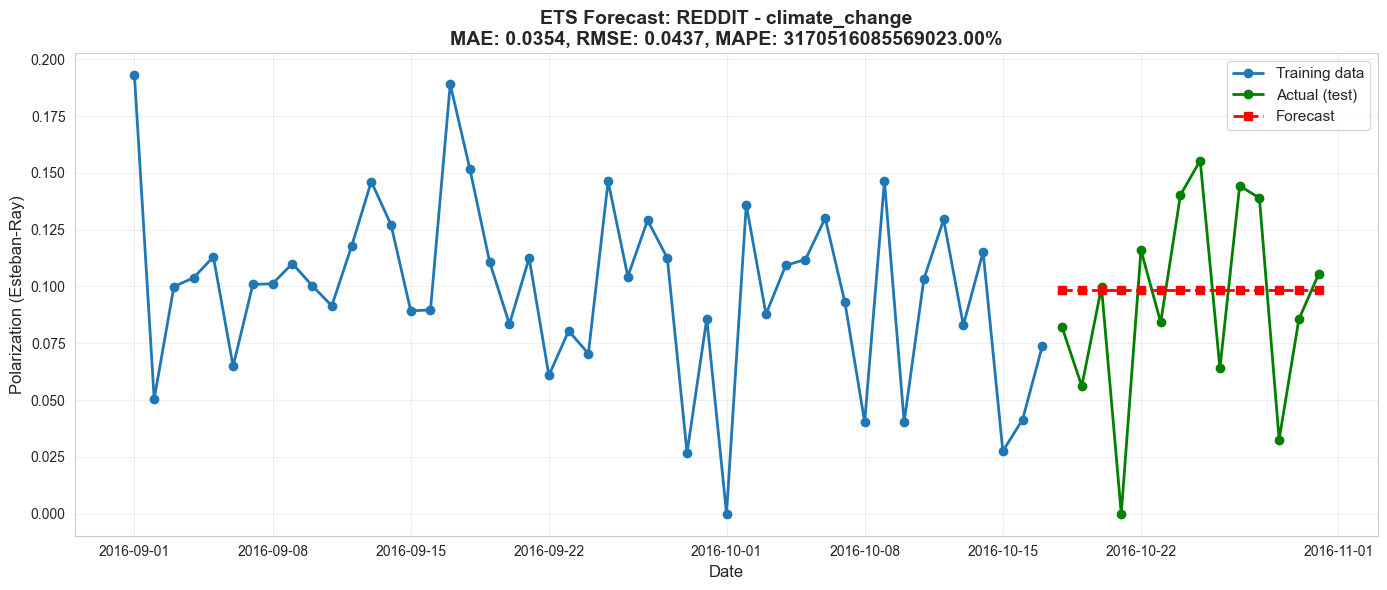

✓ Saved: ets_forecast_reddit_climate_change.png


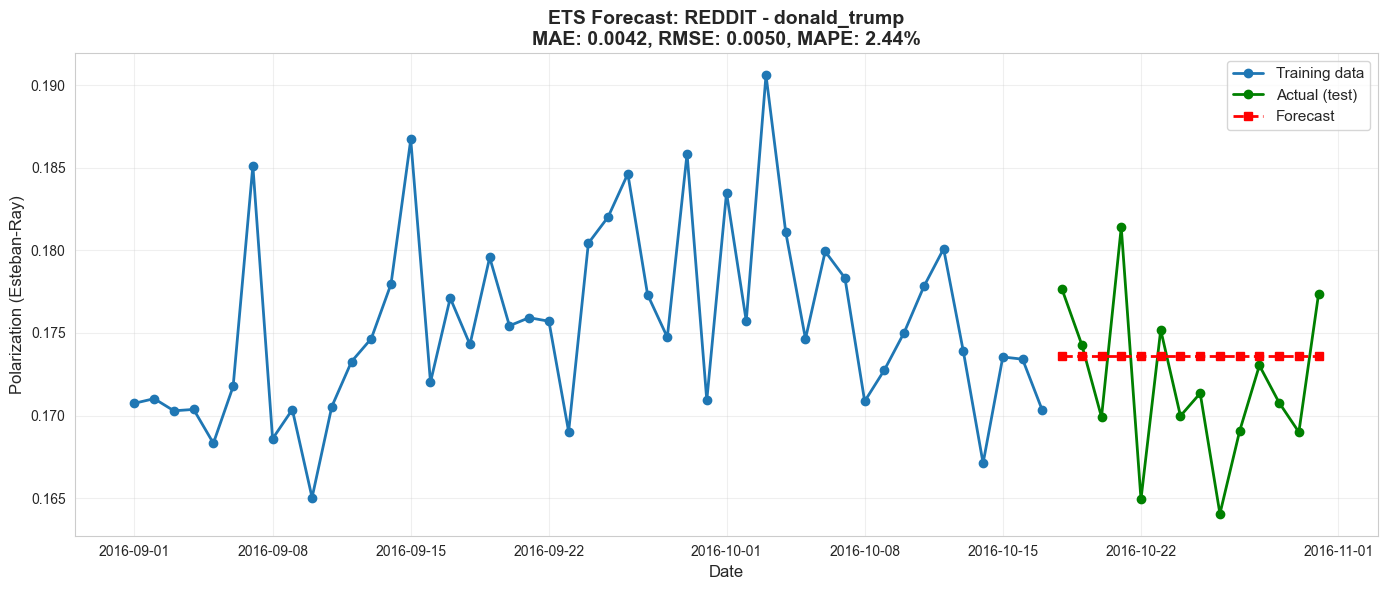

✓ Saved: ets_forecast_reddit_donald_trump.png


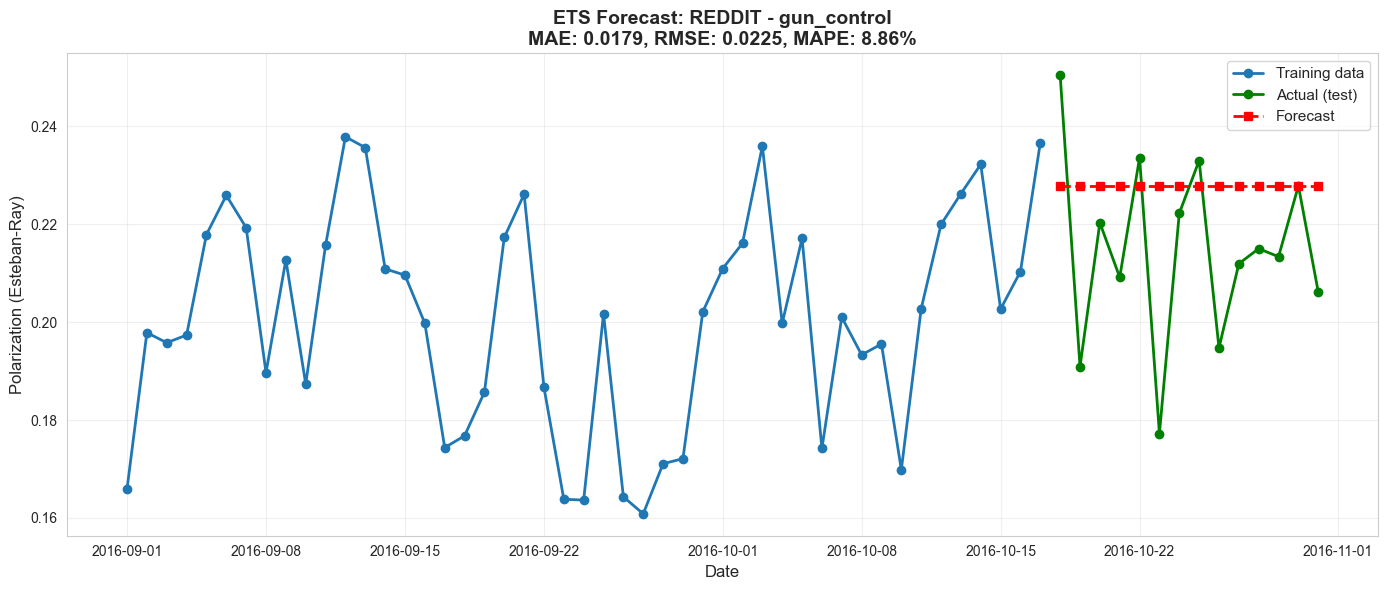

✓ Saved: ets_forecast_reddit_gun_control.png


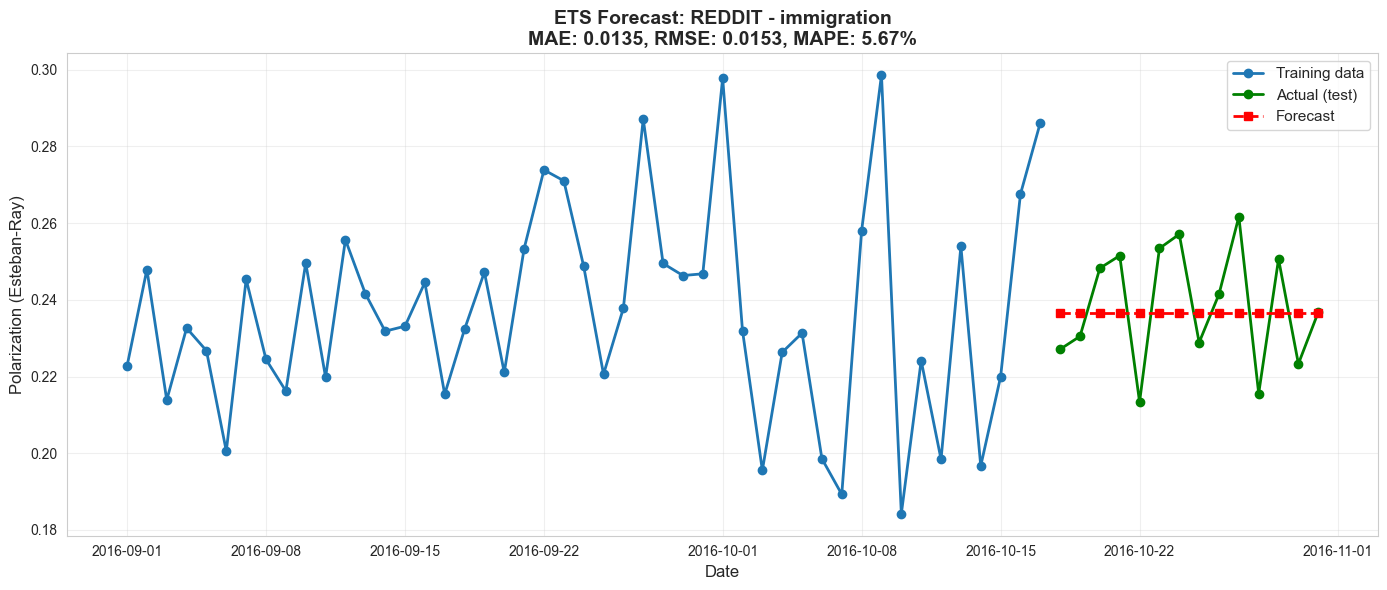

✓ Saved: ets_forecast_reddit_immigration.png


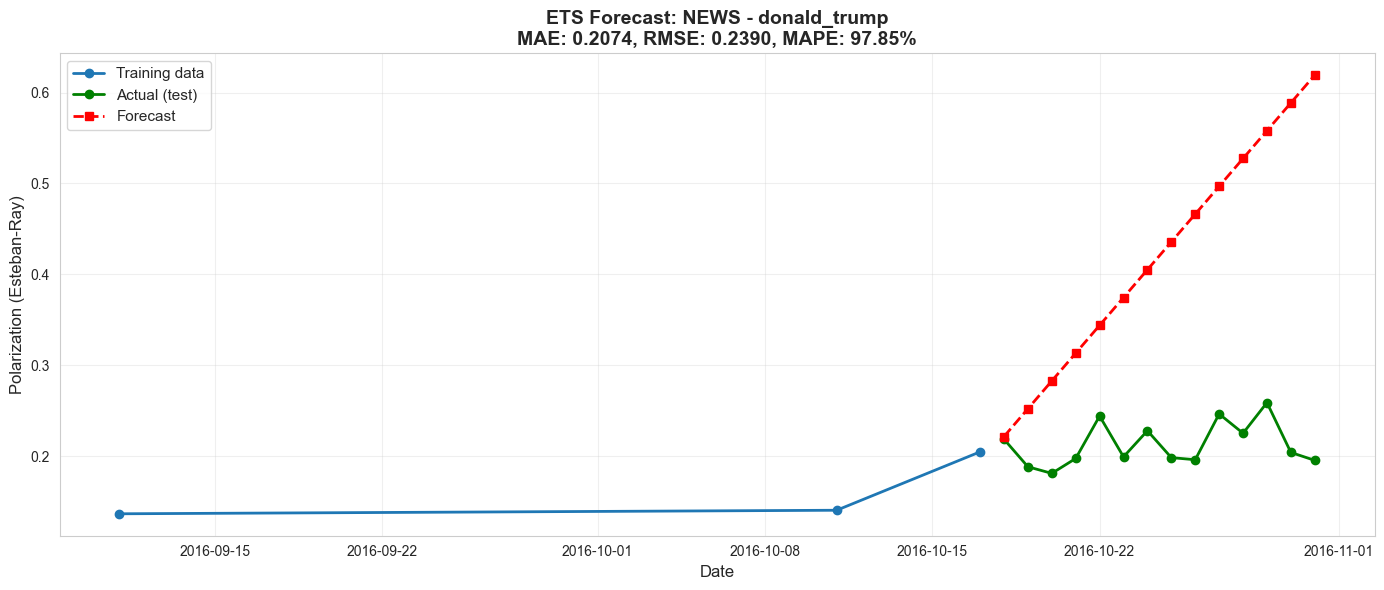

✓ Saved: ets_forecast_news_donald_trump.png


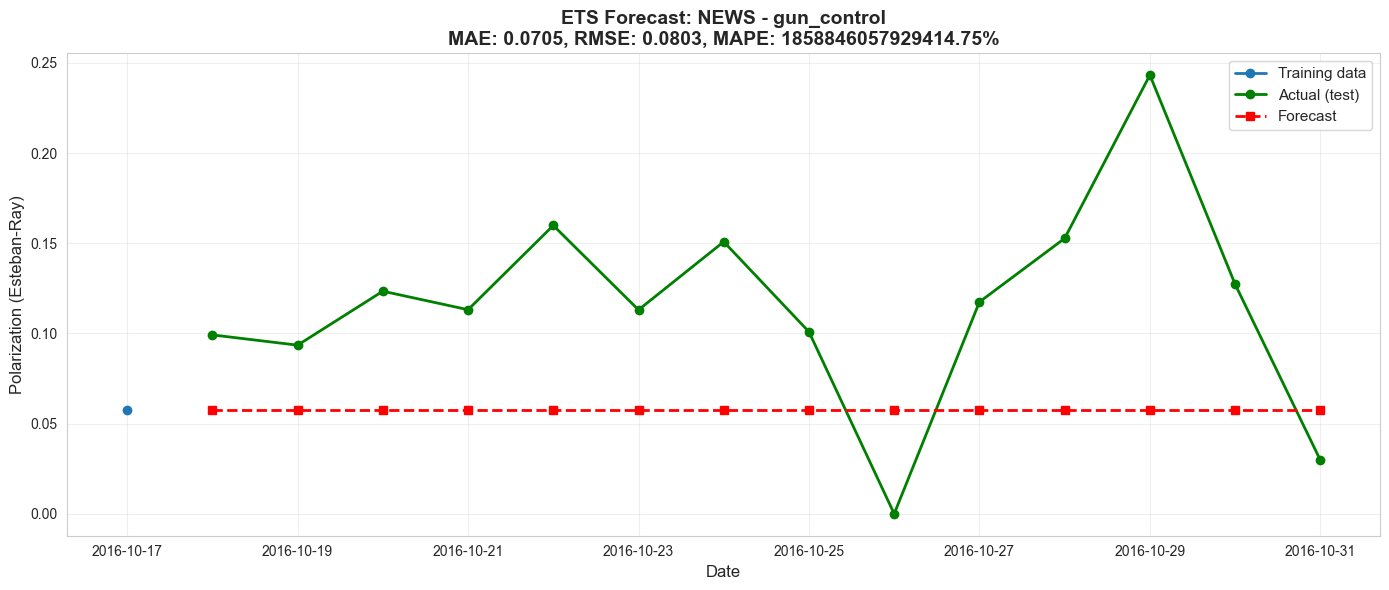

✓ Saved: ets_forecast_news_gun_control.png

✓ Generated 6 forecast plots


In [28]:
# Plot forecasts for each topic
for result in forecasting_results:
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Prepare data
    train_dates = pd.to_datetime(result['train_dates'])
    test_dates = pd.to_datetime(result['test_dates'])
    train_values = result['train_series']
    test_values = result['test_series']
    forecast_values = result['forecast']
    
    # Plot
    ax.plot(train_dates, train_values, 'o-', label='Training data', linewidth=2, markersize=6)
    ax.plot(test_dates, test_values, 'o-', label='Actual (test)', linewidth=2, markersize=6, color='green')
    ax.plot(test_dates, forecast_values, 's--', label='Forecast', linewidth=2, markersize=6, color='red')
    
    # Formatting
    ax.set_title(
        f"ETS Forecast: {result['source'].upper()} - {result['topic']}\n"
        f"MAE: {result['mae']:.4f}, RMSE: {result['rmse']:.4f}, MAPE: {result['mape']:.2f}%",
        fontsize=14,
        fontweight='bold'
    )
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Polarization (Esteban-Ray)', fontsize=12)
    ax.legend(loc='best', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save
    filename = f"ets_forecast_{result['source']}_{result['topic']}.png"
    plt.savefig(forecasting_dir / filename, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Saved: {filename}")

print(f"\n✓ Generated {len(forecasting_results)} forecast plots")

## 8. Performance Comparison

Compare performance across topics and sources.

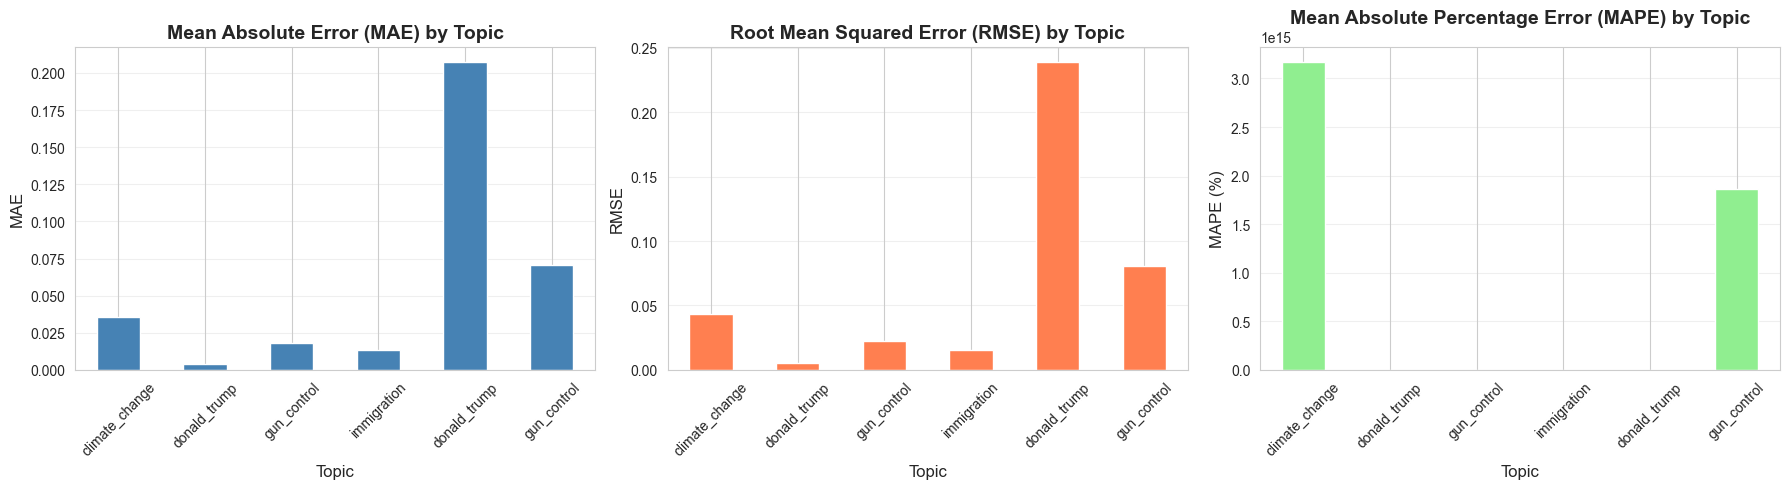

✓ Saved: ets_performance_comparison.png


In [29]:
# Performance comparison plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# MAE comparison
ax = axes[0]
results_df.plot(x='topic', y='mae', kind='bar', ax=ax, legend=False, color='steelblue')
ax.set_title('Mean Absolute Error (MAE) by Topic', fontsize=14, fontweight='bold')
ax.set_xlabel('Topic', fontsize=12)
ax.set_ylabel('MAE', fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

# RMSE comparison
ax = axes[1]
results_df.plot(x='topic', y='rmse', kind='bar', ax=ax, legend=False, color='coral')
ax.set_title('Root Mean Squared Error (RMSE) by Topic', fontsize=14, fontweight='bold')
ax.set_xlabel('Topic', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

# MAPE comparison
ax = axes[2]
results_df.plot(x='topic', y='mape', kind='bar', ax=ax, legend=False, color='lightgreen')
ax.set_title('Mean Absolute Percentage Error (MAPE) by Topic', fontsize=14, fontweight='bold')
ax.set_xlabel('Topic', fontsize=12)
ax.set_ylabel('MAPE (%)', fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(forecasting_dir / 'ets_performance_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: ets_performance_comparison.png")

## 9. Save Results

Save forecasting results and summary statistics.

In [30]:
# Save detailed results
results_file = forecasting_dir / '30_ets_forecasting_results.json'
with open(results_file, 'w') as f:
    json.dump(forecasting_results, f, indent=2, default=str)

print(f"✓ Saved detailed results: {results_file}")

# Save summary statistics
summary = {
    'notebook': '30_ets_forecasting',
    'timestamp': datetime.now().isoformat(),
    'model': 'ETS (Exponential Smoothing State Space)',
    'test_weeks': TEST_WEEKS,
    'forecast_horizon': FORECAST_HORIZON,
    'num_forecasts': len(forecasting_results),
    'sources': list(data_sources.keys()),
    'overall_performance': {
        'mean_mae': float(results_df['mae'].mean()),
        'mean_rmse': float(results_df['rmse'].mean()),
        'mean_mape': float(results_df['mape'].mean()),
        'median_mae': float(results_df['mae'].median()),
        'median_rmse': float(results_df['rmse'].median()),
        'median_mape': float(results_df['mape'].median())
    },
    'best_forecast': results_df.nsmallest(1, 'mae')[['source', 'topic', 'mae', 'rmse', 'mape']].to_dict('records')[0],
    'worst_forecast': results_df.nlargest(1, 'mae')[['source', 'topic', 'mae', 'rmse', 'mape']].to_dict('records')[0]
}

summary_file = forecasting_dir / '30_ets_summary.json'
with open(summary_file, 'w') as f:
    json.dump(summary, f, indent=2, default=str)

print(f"✓ Saved summary: {summary_file}")

# Save results as parquet for further analysis
results_parquet = forecasting_dir / '30_ets_results.parquet'
write_parquet(results_df, results_parquet)

print(f"✓ Saved results table: {results_parquet}")

✓ Saved detailed results: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/05_forecasting/30_ets_forecasting_results.json
✓ Saved summary: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/05_forecasting/30_ets_summary.json
✓ Wrote 6 rows to 30_ets_results.parquet (0.0 MB)
✓ Saved results table: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/05_forecasting/30_ets_results.parquet


## 10. Summary

In [31]:
# Print final summary
print("\n" + "="*80)
print("ETS FORECASTING COMPLETE")
print("="*80)

print(f"\n📊 FORECASTING SUMMARY:")
print(f"  Model: ETS (Exponential Smoothing)")
print(f"  Sources: {list(data_sources.keys())}")
print(f"  Total forecasts: {len(forecasting_results)}")
print(f"  Test horizon: {TEST_WEEKS} weeks")

print(f"\n📈 OVERALL PERFORMANCE:")
print(f"  Mean MAE: {results_df['mae'].mean():.4f}")
print(f"  Mean RMSE: {results_df['rmse'].mean():.4f}")
print(f"  Mean MAPE: {results_df['mape'].mean():.2f}%")

print(f"\n🏆 BEST FORECAST:")
best = results_df.nsmallest(1, 'mae').iloc[0]
print(f"  {best['source'].upper()} - {best['topic']}")
print(f"  MAE: {best['mae']:.4f}")
print(f"  RMSE: {best['rmse']:.4f}")
print(f"  MAPE: {best['mape']:.2f}%")

print(f"\n✅ OUTPUTS CREATED:")
print(f"  • 30_ets_forecasting_results.json (detailed results)")
print(f"  • 30_ets_summary.json (summary statistics)")
print(f"  • 30_ets_results.parquet (results table)")
print(f"  • {len(forecasting_results)} forecast plots")
print(f"  • ets_performance_comparison.png")

print("\n" + "="*80)
print("INSIGHTS")
print("="*80)
print("\n✓ ETS provides simple, interpretable baseline forecasts")
print("✓ Works well for short-term forecasting (4 weeks)")
print("✓ Automatically selects best error/trend/seasonal configuration")
print("✓ Performance varies by topic - some more predictable than others")

print("\n" + "="*80)
print("NEXT STEPS")
print("="*80)
print("\n1. TFT FORECASTING (Notebook 31):")
print("   - Temporal Fusion Transformer (deep learning)")
print("   - Can handle multiple covariates")
print("   - May capture complex patterns better than ETS")

print("\n2. CHRONOS FORECASTING (Notebook 32):")
print("   - Amazon's pretrained foundation model")
print("   - Zero-shot forecasting (no training needed)")
print("   - Compare against ETS and TFT")

print("\n3. MODEL COMPARISON:")
print("   - Compare all three approaches")
print("   - Identify which works best for polarization forecasting")
print("   - Analyze topic-specific performance")

print("\n" + "="*80)


ETS FORECASTING COMPLETE

📊 FORECASTING SUMMARY:
  Model: ETS (Exponential Smoothing)
  Sources: ['reddit', 'news']
  Total forecasts: 6
  Test horizon: 4 weeks

📈 OVERALL PERFORMANCE:
  Mean MAE: 0.0581
  Mean RMSE: 0.0676
  Mean MAPE: 838227023916425.50%

🏆 BEST FORECAST:
  REDDIT - donald_trump
  MAE: 0.0042
  RMSE: 0.0050
  MAPE: 2.44%

✅ OUTPUTS CREATED:
  • 30_ets_forecasting_results.json (detailed results)
  • 30_ets_summary.json (summary statistics)
  • 30_ets_results.parquet (results table)
  • 6 forecast plots
  • ets_performance_comparison.png

INSIGHTS

✓ ETS provides simple, interpretable baseline forecasts
✓ Works well for short-term forecasting (4 weeks)
✓ Automatically selects best error/trend/seasonal configuration
✓ Performance varies by topic - some more predictable than others

NEXT STEPS

1. TFT FORECASTING (Notebook 31):
   - Temporal Fusion Transformer (deep learning)
   - Can handle multiple covariates
   - May capture complex patterns better than ETS

2. CHRON